In this notebook, we compare GMM-MI with the [KSG estimator](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html) and the [MINE estimator](https://github.com/gtegner/mine-pytorch) on a simple bivariate Gaussian with varying level of correlation. To run this notebook you will need to install the MINE package following the instructions in the repository, which we report here. The cloning can be avoided if you use the folder already cloned for you in this repo.
```
git clone git@github.com:gtegner/mine-pytorch.git
cd mine-pytorch
pip install -e .
```
(note that to avoid conflicts you should also edit the setup file from `scikit_learn==0.22.1` to `scikit_learn>=0.22.1`).  Note the MINE results are not "reproducible", in the sense that the seed is not fixed.

### Import packages

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
# GMM-MI
from gmm_mi.mi import EstimateMI
from gmm_mi.param_holders import GMMFitParamHolder, SelectComponentsParamHolder, MIDistParamHolder
from gmm_mi.gmm import GMMWithMI as GMM
from gmm_mi.utils.analytic_MI import calculate_MI_D1_analytical
# KSG
from sklearn.feature_selection import mutual_info_regression
# MINE
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
from mine.models.mine import MutualInformationEstimator
from pytorch_lightning import Trainer
import logging
logging.getLogger().setLevel(logging.ERROR)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_gpus = 1 if device=='cuda' else 0

Device: cpu


### Calculate the true MI of the synthetic models

In [2]:
rhos = np.linspace(-0.99, 0.99, 20)
N = 2e2
n_components = 1
weights = np.array([1.])
means = np.zeros((1, 2))
# fix random state for stability across runs
random_state = 13

analytic = []
for rho in rhos:
    C0 = [[1, rho], [rho, 1]]
    covariances = np.array([C0])[0]
    analytic.append(calculate_MI_D1_analytical(covariances))

### KSG

In [3]:
knn_estimates = []
n_neighbors = 1 # keep minimum bias

initial_time = time.time()

for rho in rhos:
    C0 = [[1, rho], [rho, 1]]
    covariances = np.array([C0])
    gmm_true = GMM(n_components=n_components, weights_init=weights, 
                   means_init=means, covariances_init=covariances, random_state=random_state)
    X = gmm_true.sample(N)[0]
    knn_estimates.append(mutual_info_regression(X[:, 0].reshape(-1, 1), X[:, 1], 
                                                n_neighbors=n_neighbors))

ksg_time = time.time()-initial_time    
    
print(f'Total time for KSG: {ksg_time:.3f} s')

Total time for KSG: 0.050 s


### MINE

In [4]:
mine_estimates = []

dim = 1
lr = 1e-3
epochs = 50
batch_size = 64
loss_type = ['mine']  # mine, mine_biased, fdiv
loss = loss_type[0]

initial_time = time.time()

for rho in rhos:
    C0 = [[1, rho], [rho, 1]]
    covariances = np.array([C0])
    gmm_true = GMM(n_components=n_components, weights_init=weights, 
                   means_init=means, covariances_init=covariances, random_state=random_state)
    X = gmm_true.sample(N)[0]

    N = X.shape[0]
    train_size = int(0.9 * N)
    test_size = N - train_size

    train_set, test_set = train_test_split(X, test_size=0.1, random_state=42)

    tensor_x = torch.Tensor(train_set[:, :1]) # transform to torch tensor
    tensor_y = torch.Tensor(train_set[:, 1:]) # transform to torch tensor
    my_dataset = TensorDataset(tensor_x,tensor_y)
    train_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

    tensor_x = torch.Tensor(test_set[:, :1]) # transform to torch tensor
    tensor_y = torch.Tensor(test_set[:, 1:]) # transform to torch tensor
    my_dataset = TensorDataset(tensor_x,tensor_y)
    test_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

    kwargs = {
        'lr': lr,
        'batch_size': batch_size,
        'train_loader': train_loader,
        'test_loader': test_loader,
        'alpha': 1.
    }

    model = MutualInformationEstimator(
        dim, dim, loss=loss, **kwargs).to(device)
    
    trainer = Trainer(max_epochs=epochs, early_stop_callback=False, gpus=num_gpus)
    trainer.fit(model)
    trainer.test()

    mine_estimates.append(model.avg_test_mi)

mine_time = time.time()-initial_time    
    
print(f'Total time for MINE: {mine_time:.3f} s')

2022-09-05 14:49:31.202074: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/openmpi/lib
2022-09-05 14:49:31.202160: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Testing: 100%|██████████| 3/3 [00:00<00:00, 345.73batch/s]
Total time for MINE: 74.621 s


### GMM-MI

In [5]:
# parameters for GMM-MI, KSG and MINE comparison, notebooks 5-8
# all unspecified parameters are set to their default values

# parameters for every GMM fit that is being run
gmm_fit_params = GMMFitParamHolder(threshold_fit=1e-5,
                                   reg_covar=1e-12)

# parameters to choose the number of components
select_components_params = SelectComponentsParamHolder(n_inits=3,
                                                       n_folds=2)

# parameters for MI distribution estimation
mi_dist_params = MIDistParamHolder(n_bootstrap=100,
                                   MC_samples=1e4)

In [6]:
all_MI_estimates = np.zeros((len(rhos), 2))

initial_time = time.time()

for r, rho in enumerate(rhos):
    C0 = [[1, rho], [rho, 1]]
    covariances = np.array([C0])
    gmm_true = GMM(n_components=n_components, weights_init=weights, 
                   means_init=means, covariances_init=covariances, random_state=random_state)
    X = gmm_true.sample(N)[0]

    mi_estimator = EstimateMI(gmm_fit_params=gmm_fit_params,
                              select_components_params=select_components_params,
                              mi_dist_params=mi_dist_params)
    MI_mean, MI_std = mi_estimator.fit(X)   

    # store results
    all_MI_estimates[r, 0] = MI_mean
    all_MI_estimates[r, 1] = MI_std

gmm_mi_time = time.time()-initial_time
print(f'Total time for GMM: {gmm_mi_time:.3f} s')

Total time for GMM: 15.475 s


### Plot results

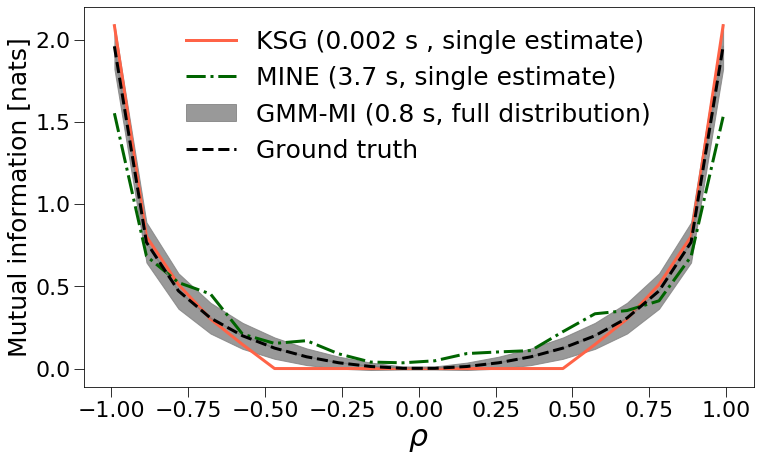

In [8]:
# let's plot the results
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

sigmas = 2
lw = 3

ax.tick_params(axis='both', which='major', labelsize=22, size=10)
ax.plot(rhos, knn_estimates, c='tomato', lw=lw, label=f'KSG ({ksg_time/len(rhos):.3f} s , single estimate)')
ax.plot(rhos, mine_estimates, c='darkgreen', ls='-.', lw=lw, label=f'MINE ({mine_time/len(rhos):.1f} s, single estimate)')
ax.plot(rhos, all_MI_estimates[:, 0], color='grey', alpha=0.8)
ax.fill_between(rhos, all_MI_estimates[:, 0] - sigmas*all_MI_estimates[:, 1], 
                all_MI_estimates[:, 0]+sigmas*all_MI_estimates[:, 1], color='grey', 
                alpha=0.8, label=f'GMM-MI ({gmm_mi_time/len(rhos):.1f} s, full distribution)')
ax.plot(rhos, analytic, ls='--', c='black', lw=lw, label='Ground truth')

handles, labels = ax.get_legend_handles_labels()
i1, i2 = -1, -2
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1] 

ax.legend(handles, labels, fontsize=25, frameon=False)
        
ax.set_xlabel(r'$\rho$', fontsize=30)
ax.set_ylabel('Mutual information [nats]', fontsize=25);

plt.savefig('./figures/D1_comparison.pdf',  bbox_inches='tight');